# Feature Extraction | Steam Game Recommender System
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid
###### AAI 695-WS2 | Spring 2023 | Final Project Team 9


---

Steam is a video game digital distriburtion service and storefront where users can purchase and play games. The purpose of this project is to construct a Recommender System (RS) to predict the top-k unplayed games for a user based user history, users with similar tastes in genres, and games with similar genres to those the user likes.

We use a [dataset from Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam). The dataset consists of three CSV files. This includes a file titled ‘Games’ contains titles of games and purchasable game content, ratings, price in USD, and release dates, a ‘Users’ CSV containing information regarding the users who have reviewed the games in the ‘Games’ CSV, and a ‘Recommendations’ CSV, which offers whether a user recommends the product they reviewed. Note that personal user information is not accessible within the files.

In this project we will use collaborative filtering to make recommendations. There are two types of collaborative filtering, user-based and item-based, which differ in how they compute similarities and make recommendations:

User-based collaborative filtering focuses on the relationships between users. It identifies users who are similar to the target user based on their past interactions with items (e.g., ratings, purchase history). Recommendations for the target user are generated by considering the preferences of similar users. In other words, it recommends items that were liked by users who have similar taste as the target user.

Item-based collaborative filtering focuses on the relationships between items. It computes similarities between items based on user interactions with them, such as ratings or purchase history. Recommendations for a target user are generated by identifying items that are similar to those the user has liked or interacted with in the past. In other words, it recommends items that are similar to those the target user has already liked.

In summary, user-based collaborative filtering focuses on finding similar users to the target user and recommends items based on the preferences of those similar users, while item-based collaborative filtering focuses on finding similar items to those the target user has liked and recommends items based on these similarities.

After exploring the data, we identify several challenges and methods we can use to overcome them, increasing the scope of the project significantly.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import sys
import os
import IPython
import psutil
import pickle

In [ ]:
# Set the project directory correctly for colab and jupyter environments
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/AAI-695/Final-Project/' # Google Drive project directory
except ImportError:
    PROJECT_DIR = os.getcwd() # Jupyter Notebook project directory

# Set filename and path variables (used to save notebook fuctions into .py file for other notebooks to access - last step)
NOTEBOOK_NAME = "user_based_collaborative_filter"
NOTEBOOK_PATH = os.path.join(PROJECT_DIR, NOTEBOOK_NAME + '.ipynb')
FUNCTIONS_DIR = os.path.join(PROJECT_DIR, 'functions/')
DATA_DIR =      os.path.join(PROJECT_DIR, 'data/')

# Add the Functions module directory to the Python path
sys.path.append(FUNCTIONS_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Preprocessing Functions

In [ ]:
# Import functions file (ignore pylance warning)
import data_preprocessing_funcs as fn

## Load Data

In [ ]:
steam_data = fn.load_data(DATA_DIR)

## Preprocess Data

In [ ]:
steam_data_filt = fn.preprocess_data(steam_data, thresh = [60000, 100, 5, 1])
df_games_filt, df_users_filt, df_recs_filt = fn.unpack_dict(steam_data_filt)

# Make sure all *users* in df_recs are in df_users & vice versa
# Make sure all *games* in df_recs are in df_games & vice versa

#####################
####  FILTERING  ####
#####################

Filter 1: Keep Reviews from Users with more than 0 hours of playtime

Games remaining (%):	 100.00%
Users remaining (%):	 99.99%
Reviews remaining (%):	 99.98%

User-Item Matrix Density (%): 0.251%

Filter 2: Keep Reviews from Users with more than 0 Games

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%

Filter 3: Keep Reviews for Games with more than 60000 reviews

Games remaining (%):	 0.47%
Users remaining (%):	 98.66%
Reviews remaining (%):	 29.90%

User-Item Matrix Density (%): 4.3024%

Minimum number of reviews per game: 60241

Filter 4: Keep Reviews from Users with more than 100 games

Games remaining (%):	 0.47%
Users remaining (%):	 36.46%
Reviews remaining (%):	 12.53%

User-Item Matrix Density (%): 4.8247%

Minimum number of games per user: 100

Filter: Keep Reviews from Users with more than 5 Reviews

Games remaining (%):	 0.47%

## Split the Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Function to split data for a single user into train and test sets
def split_user_data(user_data, test_size=0.2):

    train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
    return train_data, test_data

# Remove users with no rating variance
# df_recs_filt = df_recs_filt.groupby('user_id').filter(lambda x: x['is_recommended'].nunique() > 1)


# Group data by user_id and apply the split_user_data function to each group
# Store the resulting train and test DataFrames in separate lists
train_dfs, test_dfs = zip(*df_recs_filt.groupby('user_id').apply(lambda x: split_user_data(x)).values)

# Combine the train and test DataFrames from each user into their respective final DataFrames
train_recs = pd.concat(train_dfs).reset_index(drop=True)
test_recs = pd.concat(test_dfs).reset_index(drop=True)

In [ ]:
df_games_filt.head()

,app_id,title,date_release,win,mac,linux,rating,rating_positive_ratio,game_review_count,price_final,price_original,discount,steam_deck,description,tags
8,261550,Mount & Blade II: Bannerlord,2022-10-25,True,False,False,Very Positive,87,169694,49.99,49.99,0.0,True,"A strategy/action RPG. Create a character, eng...","[Medieval, Strategy, Open World, RPG, War, Mul..."
99,362890,Black Mesa,2020-03-06,True,False,True,Overwhelmingly Positive,95,85772,19.99,19.99,0.0,True,Relive Half-Life.,"[FPS, Remake, Action, Sci-fi, First-Person, Si..."
122,582160,Assassin's Creed® Origins,2017-10-26,True,False,False,Very Positive,86,78755,59.99,59.99,0.0,True,ASSASSIN’S CREED® ORIGINS IS A NEW BEGINNING *...,"[Open World, Assassin, Action, RPG, Stealth, A..."
172,755790,Ring of Elysium,2019-06-24,True,False,False,Mostly Positive,74,100444,0.00,0.00,0.0,True,Escape an astonishing disaster in Ring of Elys...,"[Free to Play, Battle Royale, Shooter, Multipl..."
511,552990,World of Warships,2017-11-15,True,False,False,Very Positive,80,116788,0.00,0.00,0.0,True,Immerse yourself in thrilling naval battles an...,"[Naval Combat, Free to Play, Naval, World War ..."


In [ ]:
df_users_filt.head()

,user_id,games_played,user_review_count
15,4660331,1903,6
30,1873936,702,21
35,2079696,224,6
38,2352799,136,7
41,2413568,305,7


In [ ]:
df_recs_filt.head()

,app_id,helpful,funny,date,is_recommended,hours_played,user_id,review_id
121,107410,0,0,2015-07-14,False,119.1,1542601,121
425,275850,0,0,2020-10-10,True,13.6,2674737,425
449,270880,0,0,2022-07-30,True,4.4,3368725,449
452,1174180,7,0,2020-09-26,True,5.3,3575363,452
756,284160,2,0,2019-05-08,False,39.4,2145529,756


### Feature Extraction

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

# Merge the dataframes
merged_data = pd.merge(df_recs_filt, df_users_filt, on='user_id')
merged_data = pd.merge(merged_data, df_games_filt, on='app_id')

# Define the numerical mapping for rating categories
rating_mapping = {
    'Overwhelmingly Positive': 1,
    'Very Positive': 0.75,
    'Mostly Positive': 0.5,
    'Positive': 0.25,
    'Mixed': 0,
    'Negative': -0.25,
    'Mostly Negative': -0.5,
    'Very Negative': -0.75,
    'Overwhelmingly Negative': -1
}

# Apply the mapping to the 'rating' column
merged_data['rating_numeric'] = merged_data['rating'].map(rating_mapping)

# Temporal features
merged_data['days_since_release'] = (pd.to_datetime(merged_data['date']) - pd.to_datetime(merged_data['date_release'])).dt.days
merged_data['month'] = pd.to_datetime(merged_data['date']).dt.month

# User-based features
user_features = merged_data.groupby('user_id').agg(
    user_avg_playtime=('hours_played', 'mean'),       # Average playtime across all games for a user
    user_avg_days_since_release=('days_since_release', 'mean'),  # Average days since release for the games a user has reviewed
    user_avg_review=('is_recommended', 'mean')  # Average of is_recommended values for each user's reviews
)
merged_data = merged_data.merge(user_features, on='user_id', how='left')

# Game-based features
game_features = merged_data.groupby('app_id').agg(
    game_avg_playtime=('hours_played', 'mean'),  # Average playtime per game across all users
)
merged_data = merged_data.merge(game_features, on='app_id')

# Interaction-based features
merged_data['user_game_playtime_ratio'] = merged_data['hours_played'] / merged_data['user_avg_playtime']  # Ratio of playtime for a specific game to the user's average playtime across all games
merged_data['rating_deviation'] = merged_data['is_recommended'].astype(int) - merged_data['rating_numeric']  # Difference between the boolean recommendation and the numerical rating of the game

merged_data['is_recommended_numeric'] = merged_data['is_recommended'].astype(int)

# Make sure to drop any unnecessary columns or fill in missing values


In [ ]:
print(merged_data['rating'].unique())
print(merged_data['rating_numeric'].unique())

['Very Positive' 'Overwhelmingly Positive' 'Mostly Positive' 'Mixed']
[0.75 1.   0.5  0.  ]


### Exploratory Data Analysis (EDA)
We perform EDA on the dataset to understand the distributions, correlations, and trends among the features and target variable (rating or recommendation). Use visualization techniques such as scatter plots, histograms, box plots, and heatmaps to help identify patterns and relationships.

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81640 entries, 0 to 81639
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   app_id                       81640 non-null  int64  
 1   helpful                      81640 non-null  int64  
 2   funny                        81640 non-null  int64  
 3   date                         81640 non-null  object 
 4   is_recommended               81640 non-null  bool   
 5   hours_played                 81640 non-null  float64
 6   user_id                      81640 non-null  int64  
 7   review_id                    81640 non-null  int64  
 8   games_played                 81640 non-null  int64  
 9   user_review_count            81640 non-null  int64  
 10  title                        81640 non-null  object 
 11  date_release                 81640 non-null  object 
 12  win                          81640 non-null  bool   
 13  mac             

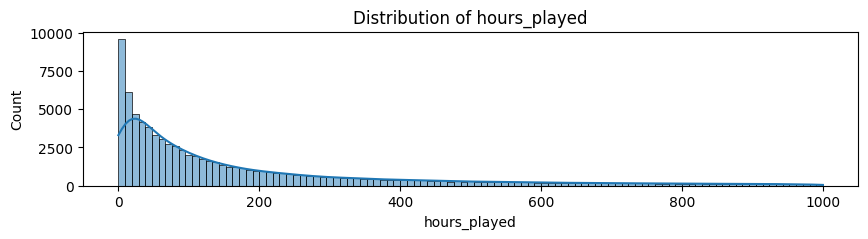

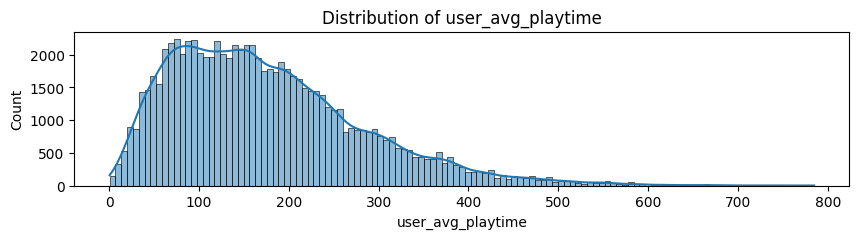

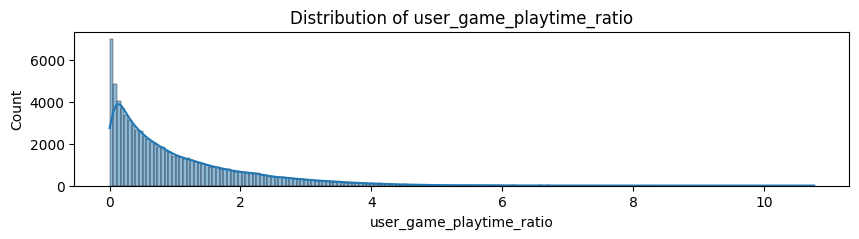

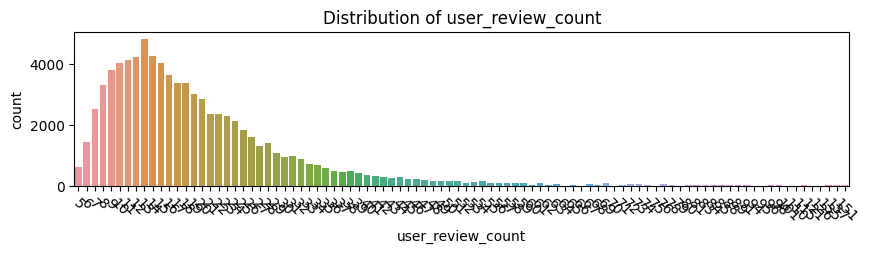

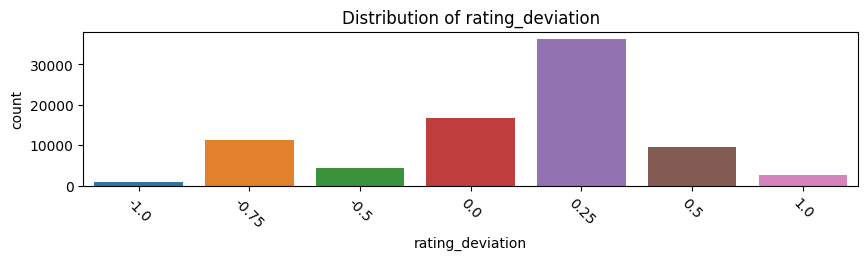

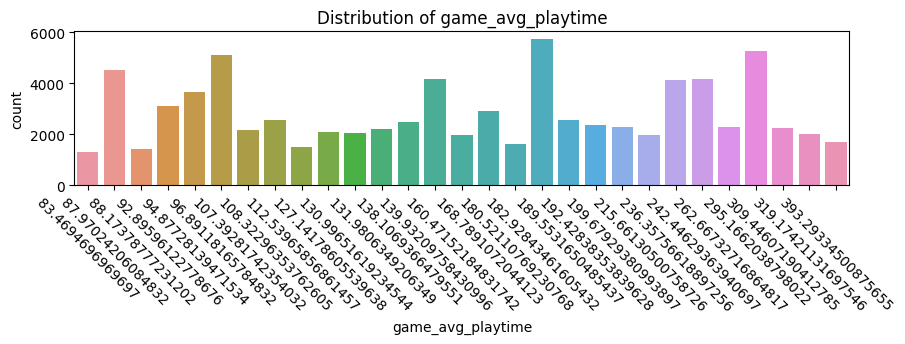

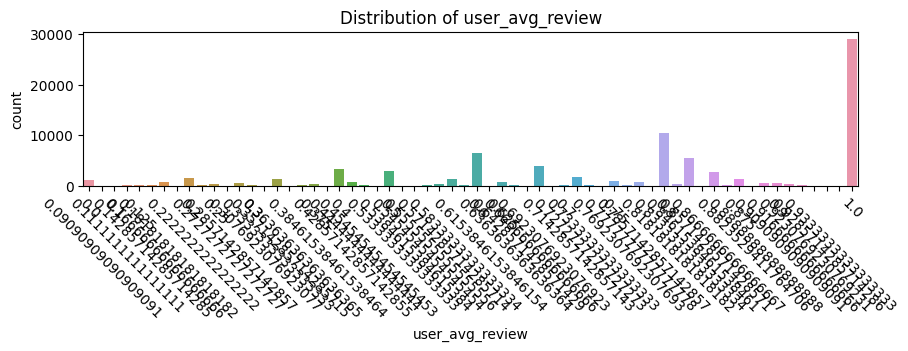

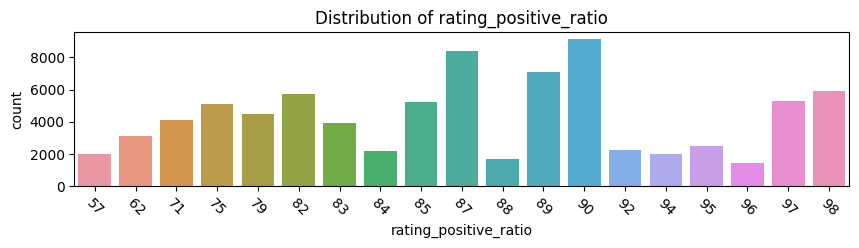

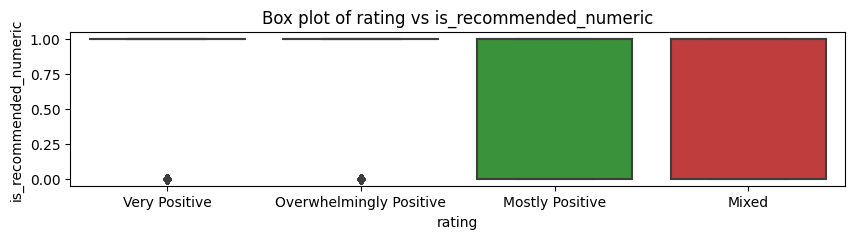

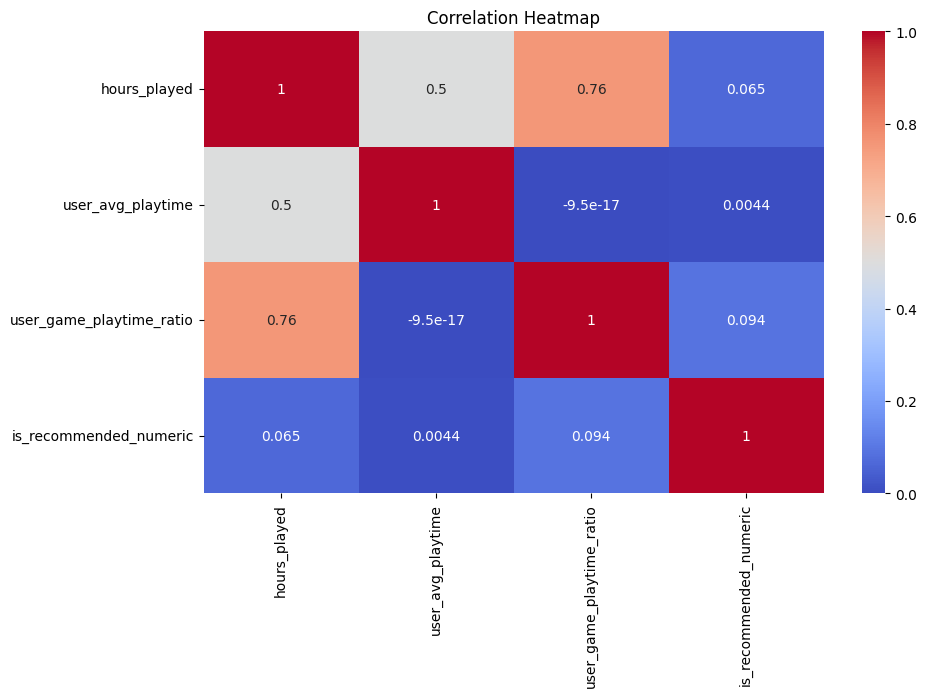

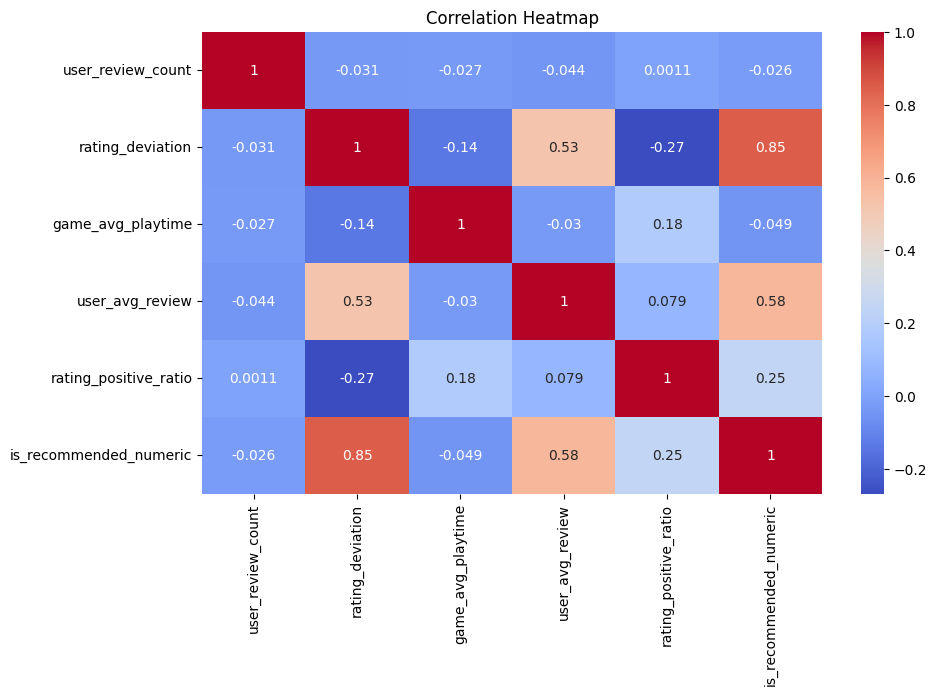

Correlations in Continuous Features:
                          hours_played  user_avg_playtime  \
hours_played                    1.0000             0.4991   
user_avg_playtime               0.4991             1.0000   
user_game_playtime_ratio        0.7554            -0.0000   
is_recommended_numeric          0.0652             0.0044   

                          user_game_playtime_ratio  is_recommended_numeric  
hours_played                                0.7554                  0.0652  
user_avg_playtime                          -0.0000                  0.0044  
user_game_playtime_ratio                    1.0000                  0.0936  
is_recommended_numeric                      0.0936                  1.0000  

Correlations in Discrete Features:
                        user_review_count  rating_deviation  \
user_review_count                  1.0000           -0.0312   
rating_deviation                  -0.0312            1.0000   
game_avg_playtime                 -0.0271      

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Continuous variables
continuous_features = ['hours_played', 'user_avg_playtime', 'user_game_playtime_ratio']

for feature in continuous_features:
    plt.figure(figsize=(10, 2))
    sns.histplot(data=merged_data, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Discrete variables
discrete_features = ['user_review_count', 'rating_deviation', 'game_avg_playtime', 'user_avg_review', 'rating_positive_ratio']

for feature in discrete_features:
    plt.figure(figsize=(10, 2))
    sns.countplot(x=feature, data=merged_data)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=-45)
    plt.show()

# Box plots for categorical features against target variable
categorical_features = ['rating']

for feature in categorical_features:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=feature, y='is_recommended_numeric', data=merged_data)
    plt.title(f'Box plot of {feature} vs is_recommended_numeric')
    plt.show()
    
# Correlation heatmap for continuous variables
plt.figure(figsize=(10, 6))
corr_matrix_continuous = merged_data[continuous_features + ['is_recommended_numeric']].corr(method='pearson')
sns.heatmap(corr_matrix_continuous, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_data = merged_data[discrete_features + ['is_recommended_numeric']]
scaled_feature_data = scaler.fit_transform(feature_data)
scaled_feature_data = pd.DataFrame(scaled_feature_data, columns=feature_data.columns)

# Correlation heatmap for discrete variables
plt.figure(figsize=(10, 6))
# corr_matrix = merged_data[discrete_features + ['is_recommended_numeric'] + existing_discrete_features].corr(method='kendall')
corr_matrix_discrete = scaled_feature_data.corr(method='pearson')
sns.heatmap(corr_matrix_discrete, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Print the correlation matrix as text
print(f'Correlations in Continuous Features:\n{corr_matrix_continuous.round(4)}\n')
print(f'Correlations in Discrete Features:\n{corr_matrix_discrete.round(4)}')

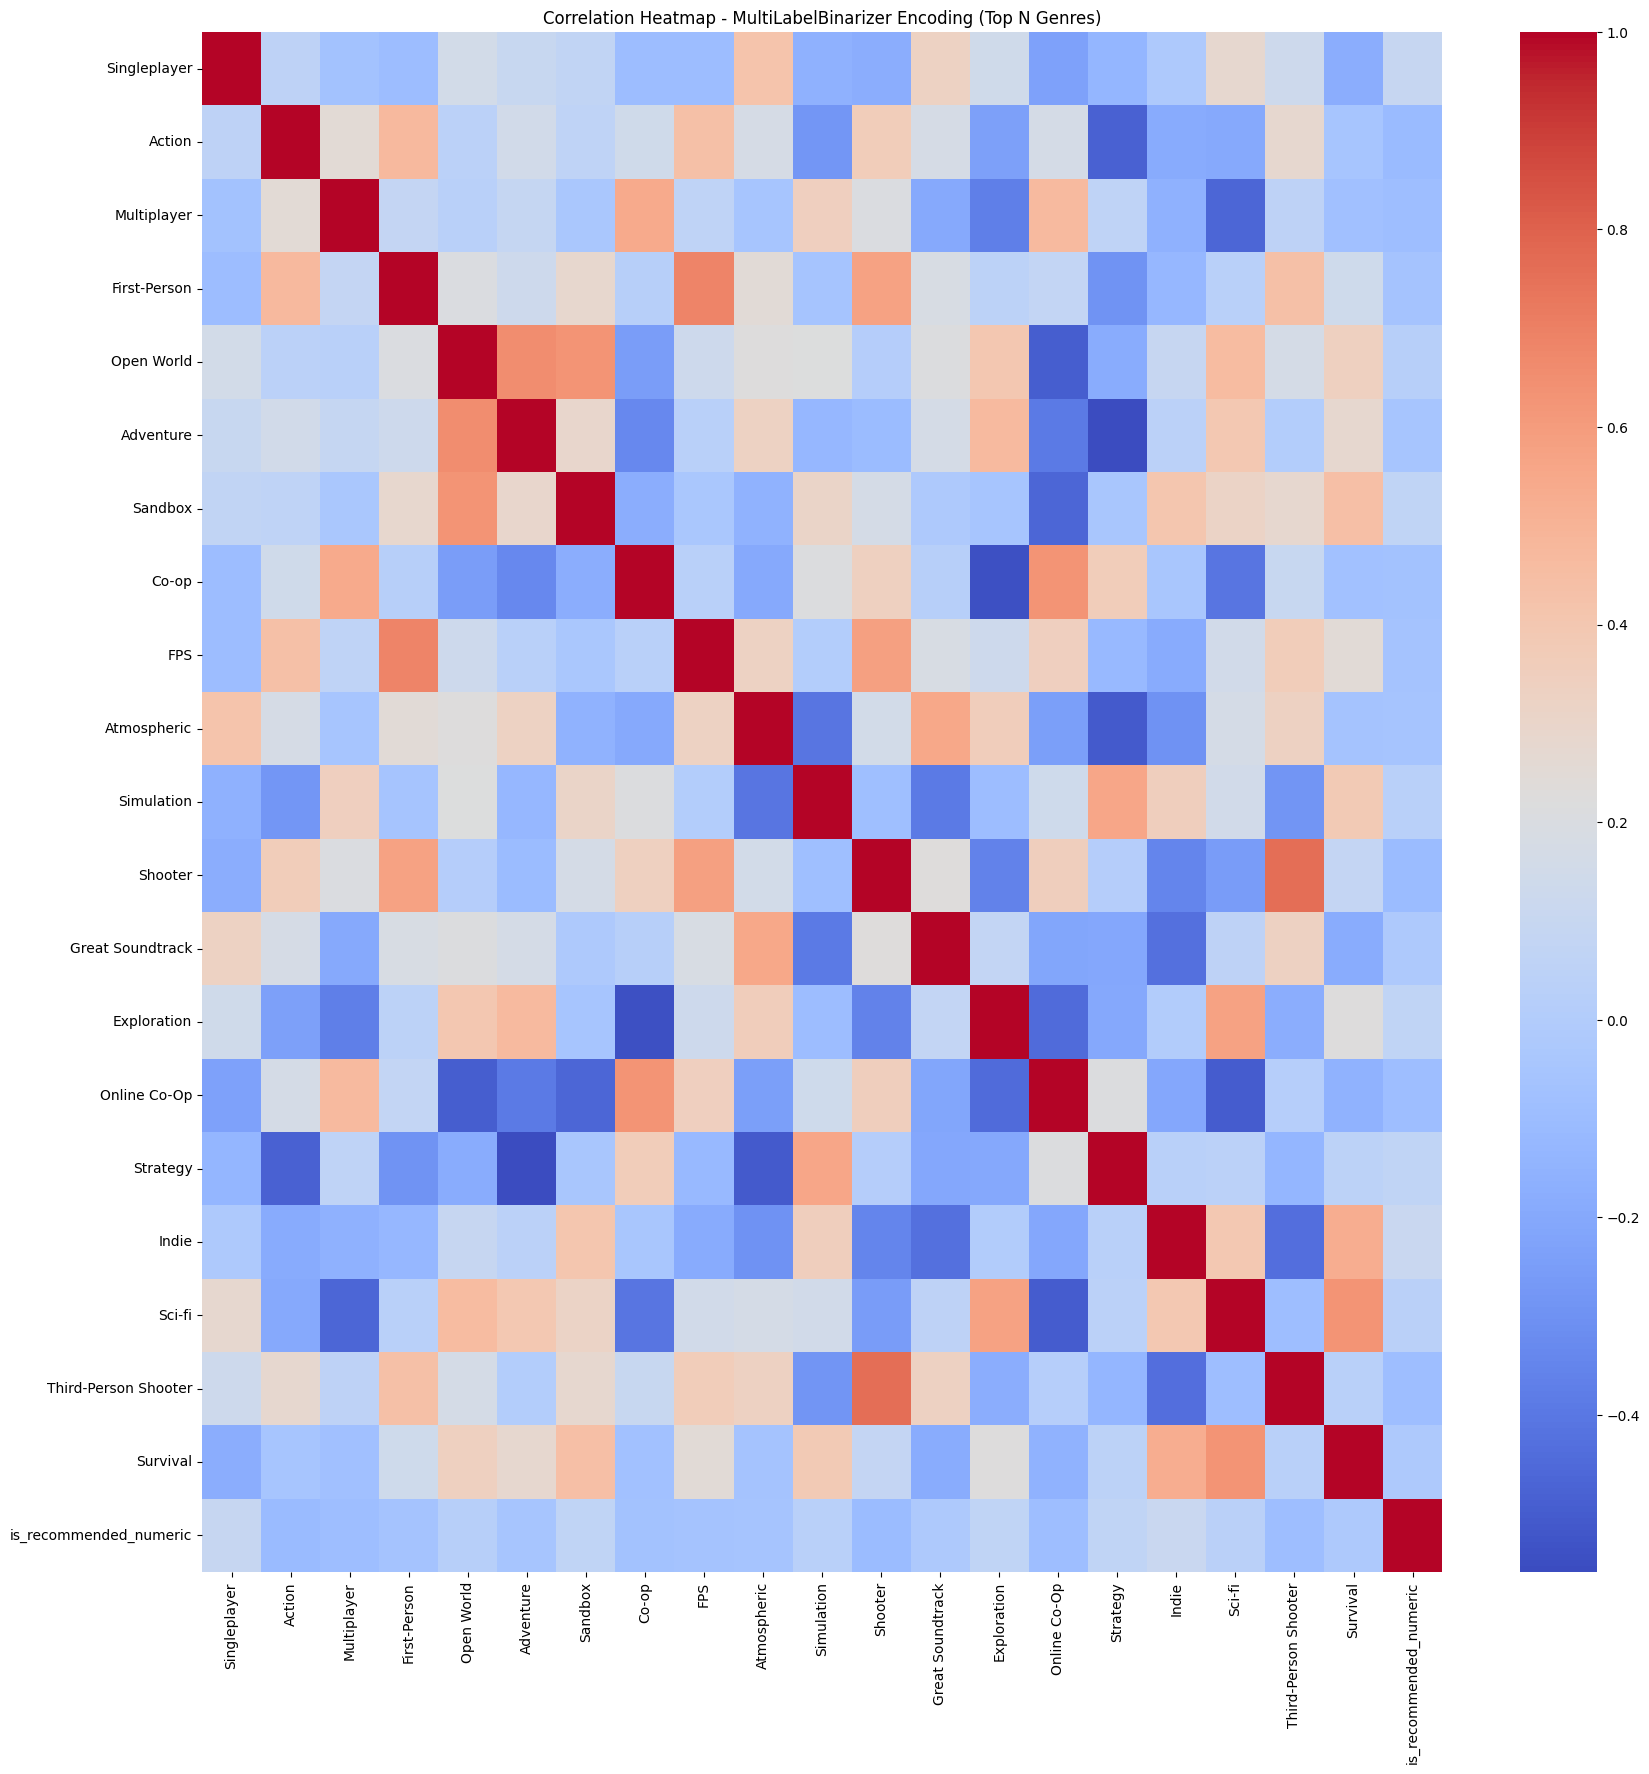

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb_encoded_genres = mlb.fit_transform(merged_data['tags'])

# Create a DataFrame with encoded genres
mlb_genre_data = pd.DataFrame(mlb_encoded_genres, columns=mlb.classes_)

# Combine encoded genres with 'is_recommended_numeric'
mlb_genre_data = pd.concat([mlb_genre_data, merged_data['is_recommended_numeric']], axis=1)

# Select the top N most frequent genres and create a new dataframe with only these genres
N = 20
top_N_genres = mlb_genre_data.drop('is_recommended_numeric', axis=1).sum().nlargest(N).index
mlb_genre_data_top_N = mlb_genre_data[top_N_genres]

# Add 'is_recommended_numeric' back to the filtered dataframe
mlb_genre_data_top_N = pd.concat([mlb_genre_data_top_N, mlb_genre_data['is_recommended_numeric']], axis=1)

# Correlation heatmap for top N genres encoded with MultiLabelBinarizer
plt.figure(figsize=(20, 20))
mlb_genre_corr = mlb_genre_data_top_N.corr(method='spearman')
sns.heatmap(mlb_genre_corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap - MultiLabelBinarizer Encoding (Top N Genres)')
plt.show()


<ipython-input-25-3ada3265e6b3>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  extended_data_corr = extended_data.corr(method='spearman')


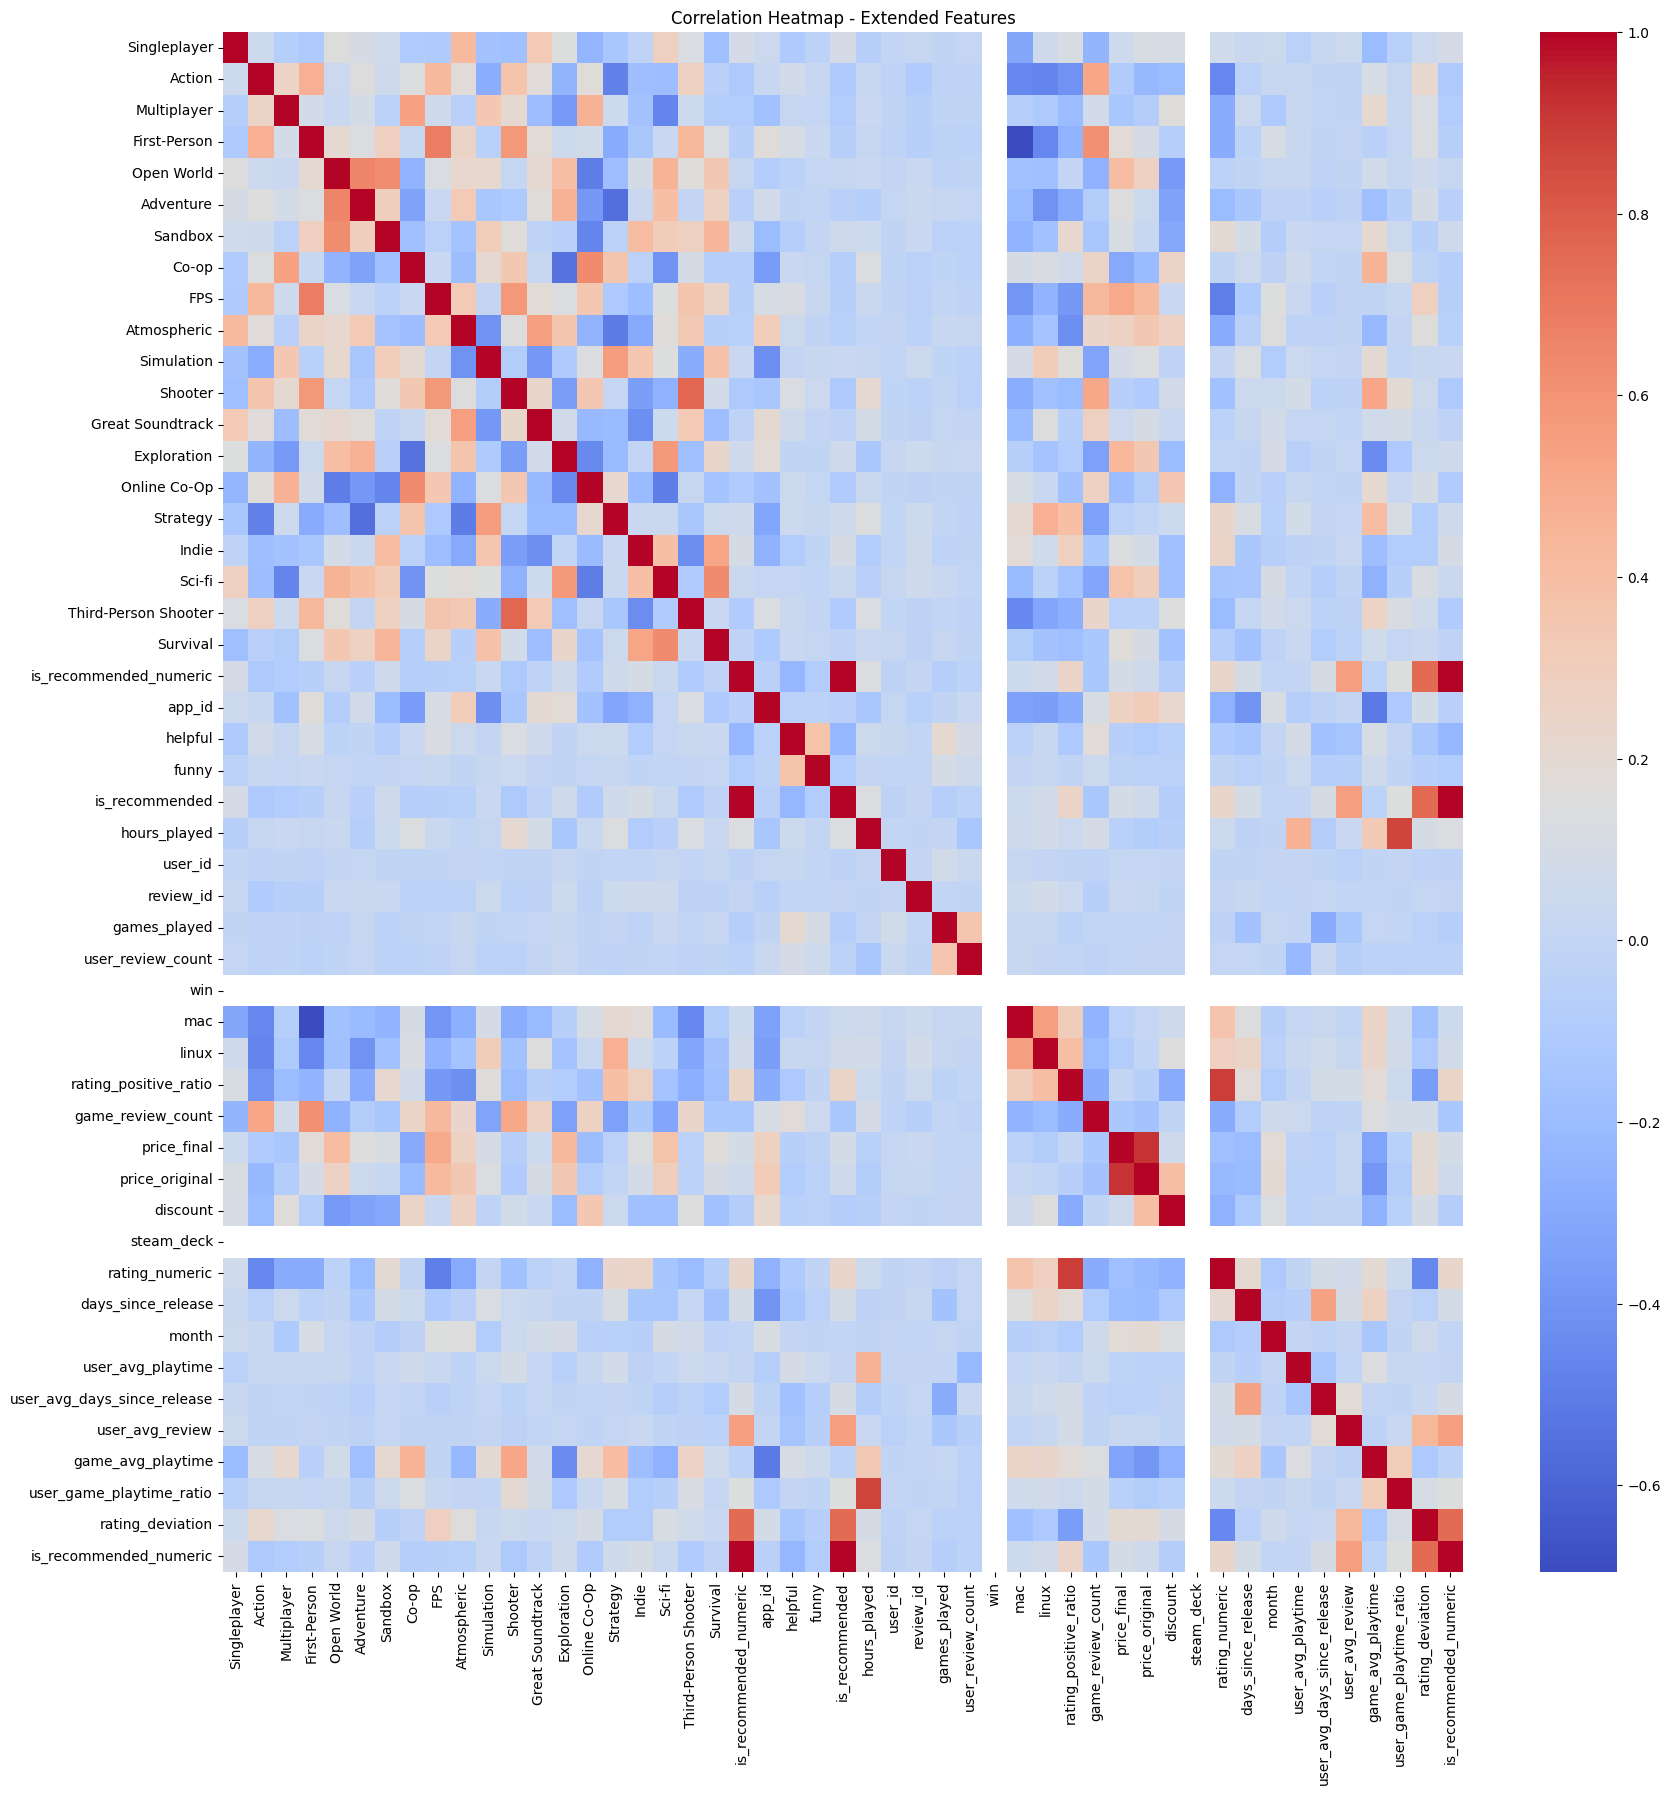

In [ ]:
# Combine these additional features with the genre data
extended_data = pd.concat([mlb_genre_data_top_N, merged_data], axis=1)#[['helpful', 'funny', 'price_final', 'rating_numeric', 'days_since_release']]], axis=1)

# Calculate correlations
extended_data_corr = extended_data.corr(method='spearman')

# Visualize the correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(extended_data_corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap - Extended Features')
plt.show()

Interpretting results to understand the relationships between the variables:

The values in the correlation matrix represent the Pearson correlation coefficients between each pair of variables, which can range from -1 (perfect negative correlation) to 1 (perfect positive correlation). A value close to 0 indicates little to no correlation between the variables.

- __hours__ (the time spent playing a game) has a relatively strong positive correlation with __user_game_playtime_ratio__ (0.7554), indicating that as the number of hours played increases, the ratio of playtime in a specific game compared to the total playtime across all games also increases.
- __hours__ also shows a positive correlation with __user_avg_playtime__ (0.4991) and __game_avg_playtime__ (0.3596). This suggests that users who spend more hours playing a game generally have higher average playtimes, and they tend to play games with higher average playtimes.
- __user_review_count__ has weak negative correlations with __hours__ (-0.0562) and __user_avg_playtime__ (-0.1126), indicating that users who write more reviews tend to have slightly lower playtimes.
- __rating_deviation__ has a strong positive correlation with __is_recommended_numeric__ (0.8498). This suggests that a higher rating deviation (a higher difference between a user's review rating and the game's average rating) is associated with a higher likelihood of recommending the game.
- __user_avg_review__ also has a moderate positive correlation with __is_recommended_numeric__ (0.5789), which indicates that users who write longer reviews are more likely to recommend the game.

Some other correlations are weak or near 0, suggesting little or no relationship between those pairs of variables.
These insights can help us better understand the relationships between the different features and how they affect whether a user recommends a game or not. However, these correlations do not imply causation; further analysis would be required to establish a causal relationship between these features.

In [ ]:
extended_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81640 entries, 0 to 81639
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Singleplayer                 81640 non-null  int64  
 1   Action                       81640 non-null  int64  
 2   Multiplayer                  81640 non-null  int64  
 3   First-Person                 81640 non-null  int64  
 4   Open World                   81640 non-null  int64  
 5   Adventure                    81640 non-null  int64  
 6   Sandbox                      81640 non-null  int64  
 7   Co-op                        81640 non-null  int64  
 8   FPS                          81640 non-null  int64  
 9   Atmospheric                  81640 non-null  int64  
 10  Simulation                   81640 non-null  int64  
 11  Shooter                      81640 non-null  int64  
 12  Great Soundtrack             81640 non-null  int64  
 13  Exploration     

### Feature importance: 
We now use a baseline model to calculate feature importance. This will provide you with a ranking of the features based on their contribution to the model's performance. Features with high importance are good candidates to include in your content-boosted collaborative filtering.

We can use models such as a decision tree, random forest, or gradient boosting machine, but using a Random Forest might be a better choice over a Decision Tree or Gradient Boosting Machine for calculating feature importance. 

- __Decision Tree:__ A single decision tree is prone to overfitting the data, making its feature importance measures less reliable. This issue can be addressed by using an ensemble method like Random Forest.
- __Gradient Boosting Machine:__ Although it is a powerful method, GBM is more complex and computationally intensive compared to Random Forest. For the purpose of feature selection, a simpler model with fewer parameters to tune (like Random Forest) might be more suitable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare the dataset
numeric_columns = extended_data.select_dtypes(include=[np.number]).columns
X = extended_data[numeric_columns].drop(columns=['is_recommended_numeric'])
y = extended_data['is_recommended_numeric']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier and fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate feature importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)

# Display the feature importances
feature_importances.head(10).style.hide(axis='index')


feature,importance
rating_deviation,0.667016
user_avg_review,0.144851
rating_positive_ratio,0.022540
user_game_playtime_ratio,0.018971
helpful,0.018329
hours_played,0.017740
rating_numeric,0.014135
days_since_release,0.009786
user_avg_days_since_release,0.007040
price_final,0.006562


The Random Forest classifier has provided a ranking of features based on their importance in predicting whether a user recommends a game or not. Here's an interpretation of the results:

- __rating_deviation:__ This has the highest importance, indicating that the deviation between a user's rating and the game's average rating is an important factor in determining whether a user will recommend a game.
- __user_avg_review:__ The second most important feature is the user's average review score across all the games they've played. This suggests that a user's overall sentiment towards games may influence their recommendations.
- __rating_positive_ratio:__ The ratio of positive ratings a game receives is the third most important feature, which implies that games with higher positive ratings are more likely to be recommended by users.

The remaining features have lower importance scores. We want to focus on the top features for out content-boosted collaborative filtering algorithm to ensure that the most important factors are taken into consideration. 

To get the features from __extended_data__ back into __df_rec_filt__, we merge the features from __extended_data__ into __df_rec_filt__ and store the result in a new dataframe called __df_rec_filt_extended__. 

To ensure that both app-specific data and user-specific data is populated correctly for each row in __df_recs_filt__, we merge using the common keys shared between the two dataframes being merged, __app_id__ and __user_id__. By merging on the __app_id__ and __user_id__ columns, we are combining the information from both dataframes while ensuring that the relationship between app and user information is maintained.

In [ ]:
# Select the features we want to merge into df_rec_filt
selected_features = ['app_id', 'user_id', 'rating_deviation', 'user_avg_review', 'rating_positive_ratio']

# Get a dataframe containing only the selected features from extended_data
extended_data_selected = extended_data[selected_features]

# Merge the selected features from extended_data into df_rec_filt based on both 'app_id' and 'user_id'
df_recs_filt_extended = df_recs_filt.merge(extended_data_selected, on=['app_id', 'user_id'], how='left')

Now, we can use this new dataframe, __df_recs_filt_extended__, for our content-boosted collaborative filtering.